### Load the libraries

In [1]:
# Load the libraries 
import os, sys
import pandas as pd 
from datetime import date
import numpy as np 
import scanpy as sc
import anndata as ad 
from pyensembl import EnsemblRelease
import sqlite3
import gprofiler as gp
from gprofiler import GProfiler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels import robust

/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/usr

<i><b> Print the container version </b></i>

In [2]:
# Container used for this analysis can be found here : cokorac/cs-core-image-amd64:dev
day = date.today()
print('The last use of the container:', day)

The last use of the container: 2025-02-12


<i><b> Set the home directory </b></i>

In [3]:
# Define the home_path 
os.environ['HOME_Nikola_scdgomics'] = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics"
home_path = os.getenv("HOME_Nikola_scdgomics")
home_path

'/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics'

### Load the data

In [4]:
# Load the Polioudakis and Trevino raw counts
adata_hs_ncx = sc.read_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scmorpho_final/data_versions_tissue/Adata_raw.h5ad")
# Load the Linnarsson raw counts
adata_mm_dge = sc.read_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_linnarsson_mm_dg_raw.h5ad")
# Load the Zylka raw counts 
adata_mm_ncx_zylka = sc.read_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_zylka_mm_ncx_raw.h5ad")
# Load the Ruan raw counts
adata_mm_ncx_ruan = sc.read_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_ruan_mm_ncx_raw.h5ad")

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
# Modify the var_names of the Ruan dataset
## Remove the parentheses, extra quotes and commas
adata_mm_ncx_ruan.var_names.astype(str)
adata_mm_ncx_ruan.var_names = adata_mm_ncx_ruan.var_names.str.strip("() ").str.strip("'").str.strip("'$").str.rstrip(",")
adata_mm_ncx_ruan.var_names = adata_mm_ncx_ruan.var_names.str.strip("'$")
## Remove the mmu- prefix 
adata_mm_ncx_ruan.var_names = adata_mm_ncx_ruan.var_names.str.replace("mmu-", "", regex=True)
## Print the output
adata_mm_ncx_ruan.var_names

Index(['0610005C13Rik', '0610007N19Rik', '0610007P14Rik', '0610009B22Rik',
       '0610009D07Rik', '0610009E02Rik', '0610009L18Rik', '0610009O20Rik',
       '0610010F05Rik', '0610010K14Rik',
       ...
       'Zbtb9', 'Zp3', 'mir-6374', 'mir-6383', 'mir-6418', 'mir-6951',
       'mir-6958', 'mir-7024', 'mir-8106', 'mt-Nd3'],
      dtype='object', length=21862)

In [6]:
# Re-format the obs_name for Ruan and Zylka
## Ruan
adata_mm_ncx_ruan.obs_names = adata_mm_ncx_ruan.obs['cellid']
## Zylka
adata_mm_ncx_zylka.obs_names = adata_mm_ncx_zylka.obs['CellID']

### Data wrangling

> *** NOTE: Find the downloaded ensembl releases for human and mouse genomes here : '/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/ensembl_release_104'

In [7]:
# Download the ENSEMBL RELEASE 104 

## human
#data = EnsemblRelease(104)
#data.download()
#data.index()
#all_genes = data.genes()
#protein_coding_hs = [gene.gene_name for gene in all_genes if gene.biotype == 'protein_coding']
#len(protein_coding_hs)

## mouse
#data = EnsemblRelease(104, species='mus_musculus')
#data.download()
#data.index()
#all_genes = data.genes()
#protein_coding_mm = [gene.gene_name for gene in all_genes if gene.biotype == 'protein_coding']
#len(protein_coding_hs)

In [8]:
# Import GTF files and keep only protein-coding genes
## human 
human_gtf_path = '/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/ensembl_release_104/GRCh38/ensembl104/Homo_sapiens.GRCh38.104.gtf.db'
connection_hs = sqlite3.connect(human_gtf_path)
df_hs = pd.read_sql_query("SELECT * FROM gene;", connection_hs)
df_protein_coding_hs = df_hs[df_hs['gene_biotype'] == 'protein_coding']
## mouse
mouse_gtf_path = '/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/ensembl_release_104/GRCm39/ensembl104/Mus_musculus.GRCm39.104.gtf.db'
connection_mm = sqlite3.connect(mouse_gtf_path)
df_mm = pd.read_sql_query("SELECT * FROM gene;", connection_mm)
df_protein_coding_mm = df_mm[df_mm['gene_biotype'] == 'protein_coding']

In [9]:
# Print the number of protein-coding genes
print(len(df_protein_coding_hs))
print(len(df_protein_coding_mm))

19966
21885


In [10]:
# Keep only protein coding genes
## Polioudakis and Trevino
adata_hs_ncx = adata_hs_ncx[:, adata_hs_ncx.var_names.isin(df_protein_coding_hs['gene_name'].tolist())]
## Linnarsson 
adata_mm_dge = adata_mm_dge[:, adata_mm_dge.var_names.isin(df_protein_coding_mm['gene_name'].tolist())]
## Zylka 
adata_mm_ncx_zylka = adata_mm_ncx_zylka[:, adata_mm_ncx_zylka.var_names.isin(df_protein_coding_mm['gene_name'].tolist())]
## Ruan 
adata_mm_ncx_ruan = adata_mm_ncx_ruan[:, adata_mm_ncx_ruan.var_names.isin(df_protein_coding_mm['gene_name'].tolist())]

In [11]:
# Add the dataset_of_origin column to Linnarsson dataset
## ** This column already exists for Polioudakis and Trevino
adata_mm_dge.obs['dataset_of_origin'] = 'Linnarsson'
adata_mm_ncx_zylka.obs['dataset_of_origin'] = 'Zylka'
adata_mm_ncx_ruan.obs['dataset_of_origin'] = 'Ruan'

/tmp/ipykernel_1841910/2960434068.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_mm_dge.obs['dataset_of_origin'] = 'Linnarsson'
/tmp/ipykernel_1841910/2960434068.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_mm_ncx_zylka.obs['dataset_of_origin'] = 'Zylka'
/tmp/ipykernel_1841910/2960434068.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_mm_ncx_ruan.obs['dataset_of_origin'] = 'Ruan'


### Map mouse genes to human orthologues

> *** NOTE: For more information on GProfiler.orth, visit : https://pypi.org/project/gprofiler-official/

In [12]:
# Initialize the gprofiler
gp = GProfiler(return_dataframe=True)
# Extract mouse genes as a list
mouse_genes_linnarsson = adata_mm_dge.var_names.tolist()
mouse_genes_zylka = adata_mm_ncx_zylka.var_names.tolist()
mouse_genes_ruan = adata_mm_ncx_ruan.var_names.tolist()
# Map the extracted genes to human orthologues
ortho_map_linnarsson = gp.orth(organism='mmusculus', query=mouse_genes_linnarsson, target='hsapiens')
ortho_map_zylka = gp.orth(organism='mmusculus', query=mouse_genes_zylka, target='hsapiens')
ortho_map_ruan = gp.orth(organism='mmusculus', query=mouse_genes_ruan, target='hsapiens')

In [13]:
# Remove the genes that were not successfully mapped
# Replace the 'N/A' character with numpy NaN
ortho_map_linnarsson['name'] = ortho_map_linnarsson['name'].replace('N/A', np.nan)
ortho_map_zylka['name'] = ortho_map_zylka['name'].replace('N/A', np.nan)
ortho_map_ruan['name'] = ortho_map_ruan['name'].replace('N/A', np.nan)
# Drop NaNs
ortho_map_linnarsson_clean  = ortho_map_linnarsson.dropna(subset=['name'])
ortho_map_zylka_clean  = ortho_map_zylka.dropna(subset=['name'])
ortho_map_ruan_clean  = ortho_map_ruan.dropna(subset=['name'])

In [14]:
# Map the converted genes to the adata.var_name category
## Linnarsson
mapped_genes_linnarsson = dict(zip(ortho_map_linnarsson_clean['incoming'], ortho_map_linnarsson_clean['name']))
adata_mm_dge.var_names = [mapped_genes_linnarsson.get(gene, gene) for gene in adata_mm_dge.var_names]
## Zylka
mapped_genes_zylka = dict(zip(ortho_map_zylka_clean['incoming'], ortho_map_zylka_clean['name']))
adata_mm_ncx_zylka.var_names = [mapped_genes_zylka.get(gene, gene) for gene in adata_mm_ncx_zylka.var_names]
## Ruan
mapped_genes_ruan = dict(zip(ortho_map_ruan_clean['incoming'], ortho_map_ruan_clean['name']))
adata_mm_ncx_ruan.var_names = [mapped_genes_ruan.get(gene, gene) for gene in adata_mm_ncx_ruan.var_names]

In [15]:
# Keep only the human gene names
## Linnarsson
adata_mm_dge = adata_mm_dge[:, adata_mm_dge.var_names.isin(mapped_genes_linnarsson.values())]
print(len(adata_mm_dge.var_names))
## Zylka
adata_mm_ncx_zylka = adata_mm_ncx_zylka[:, adata_mm_ncx_zylka.var_names.isin(mapped_genes_zylka.values())]
print(len(adata_mm_ncx_zylka.var_names))
## Ruan
adata_mm_ncx_ruan = adata_mm_ncx_ruan[:, adata_mm_ncx_ruan.var_names.isin(mapped_genes_ruan.values())]
print(len(adata_mm_ncx_ruan.var_names))

16598
14523
14589


### Concatenate datasets

In [16]:
# Make var_names unique
adata_mm_dge.var_names_make_unique()
adata_mm_ncx_zylka.var_names_make_unique()
adata_mm_ncx_ruan.var_names_make_unique()
adata_hs_ncx.var_names_make_unique()

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1760: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1760: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1760: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1760: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1760: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_name

In [17]:
# Concatenate the raw datasets 
adata_combined = ad.concat([adata_hs_ncx, adata_mm_dge, adata_mm_ncx_zylka, adata_mm_ncx_ruan], join = 'inner')
adata_combined

AnnData object with n_obs × n_vars = 113667 × 10801
    obs: 'dataset_of_origin'

In [18]:
# Check the 'dataset_of_origin labels
adata_combined.obs['dataset_of_origin'].unique()

array(['Polioudakis', 'Trevino', 'Linnarsson', 'Zylka', 'Ruan'],
      dtype=object)

### Data normalization, PCA and NN

In [19]:
# Create the layer for raw counts
adata_combined.layers['counts'] = adata_combined.X.toarray().copy()
# Normalize counts
sc.pp.normalize_total(adata_combined, target_sum=1e4, exclude_highly_expressed=True)
adata_combined.layers['normalized_counts'] = adata_combined.X.copy()
# Log-transform
sc.pp.log1p(adata_combined)
adata_combined.layers['log_normalized_counts'] = adata_combined.X.copy()
sc.pp.highly_variable_genes(adata_combined, subset=False)
# Scale
sc.pp.scale(adata_combined, max_value=10)
adata_combined.layers['log_normalized_scaled_counts'] = adata_combined.X.copy()

In [20]:
# Compute the PCA and NNs
sc.tl.pca(adata_combined, n_comps = 50, svd_solver='arpack', random_state=111, use_highly_variable=True)
sc.pp.neighbors(adata_combined, n_neighbors= 50, n_pcs=30, random_state=111)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
2025-02-12 16:49:56.212697: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-12 16:49:59.551077: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-12 16:49:59.551108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for pl

In [21]:
# Compute UMAPs and leiden clustering
sc.tl.umap(adata_combined, random_state=111)
sc.tl.leiden(adata_combined, resolution=1, random_state=111)

/tmp/ipykernel_1841910/3133928754.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_combined, resolution=1, random_state=111)


... storing 'dataset_of_origin' as categorical


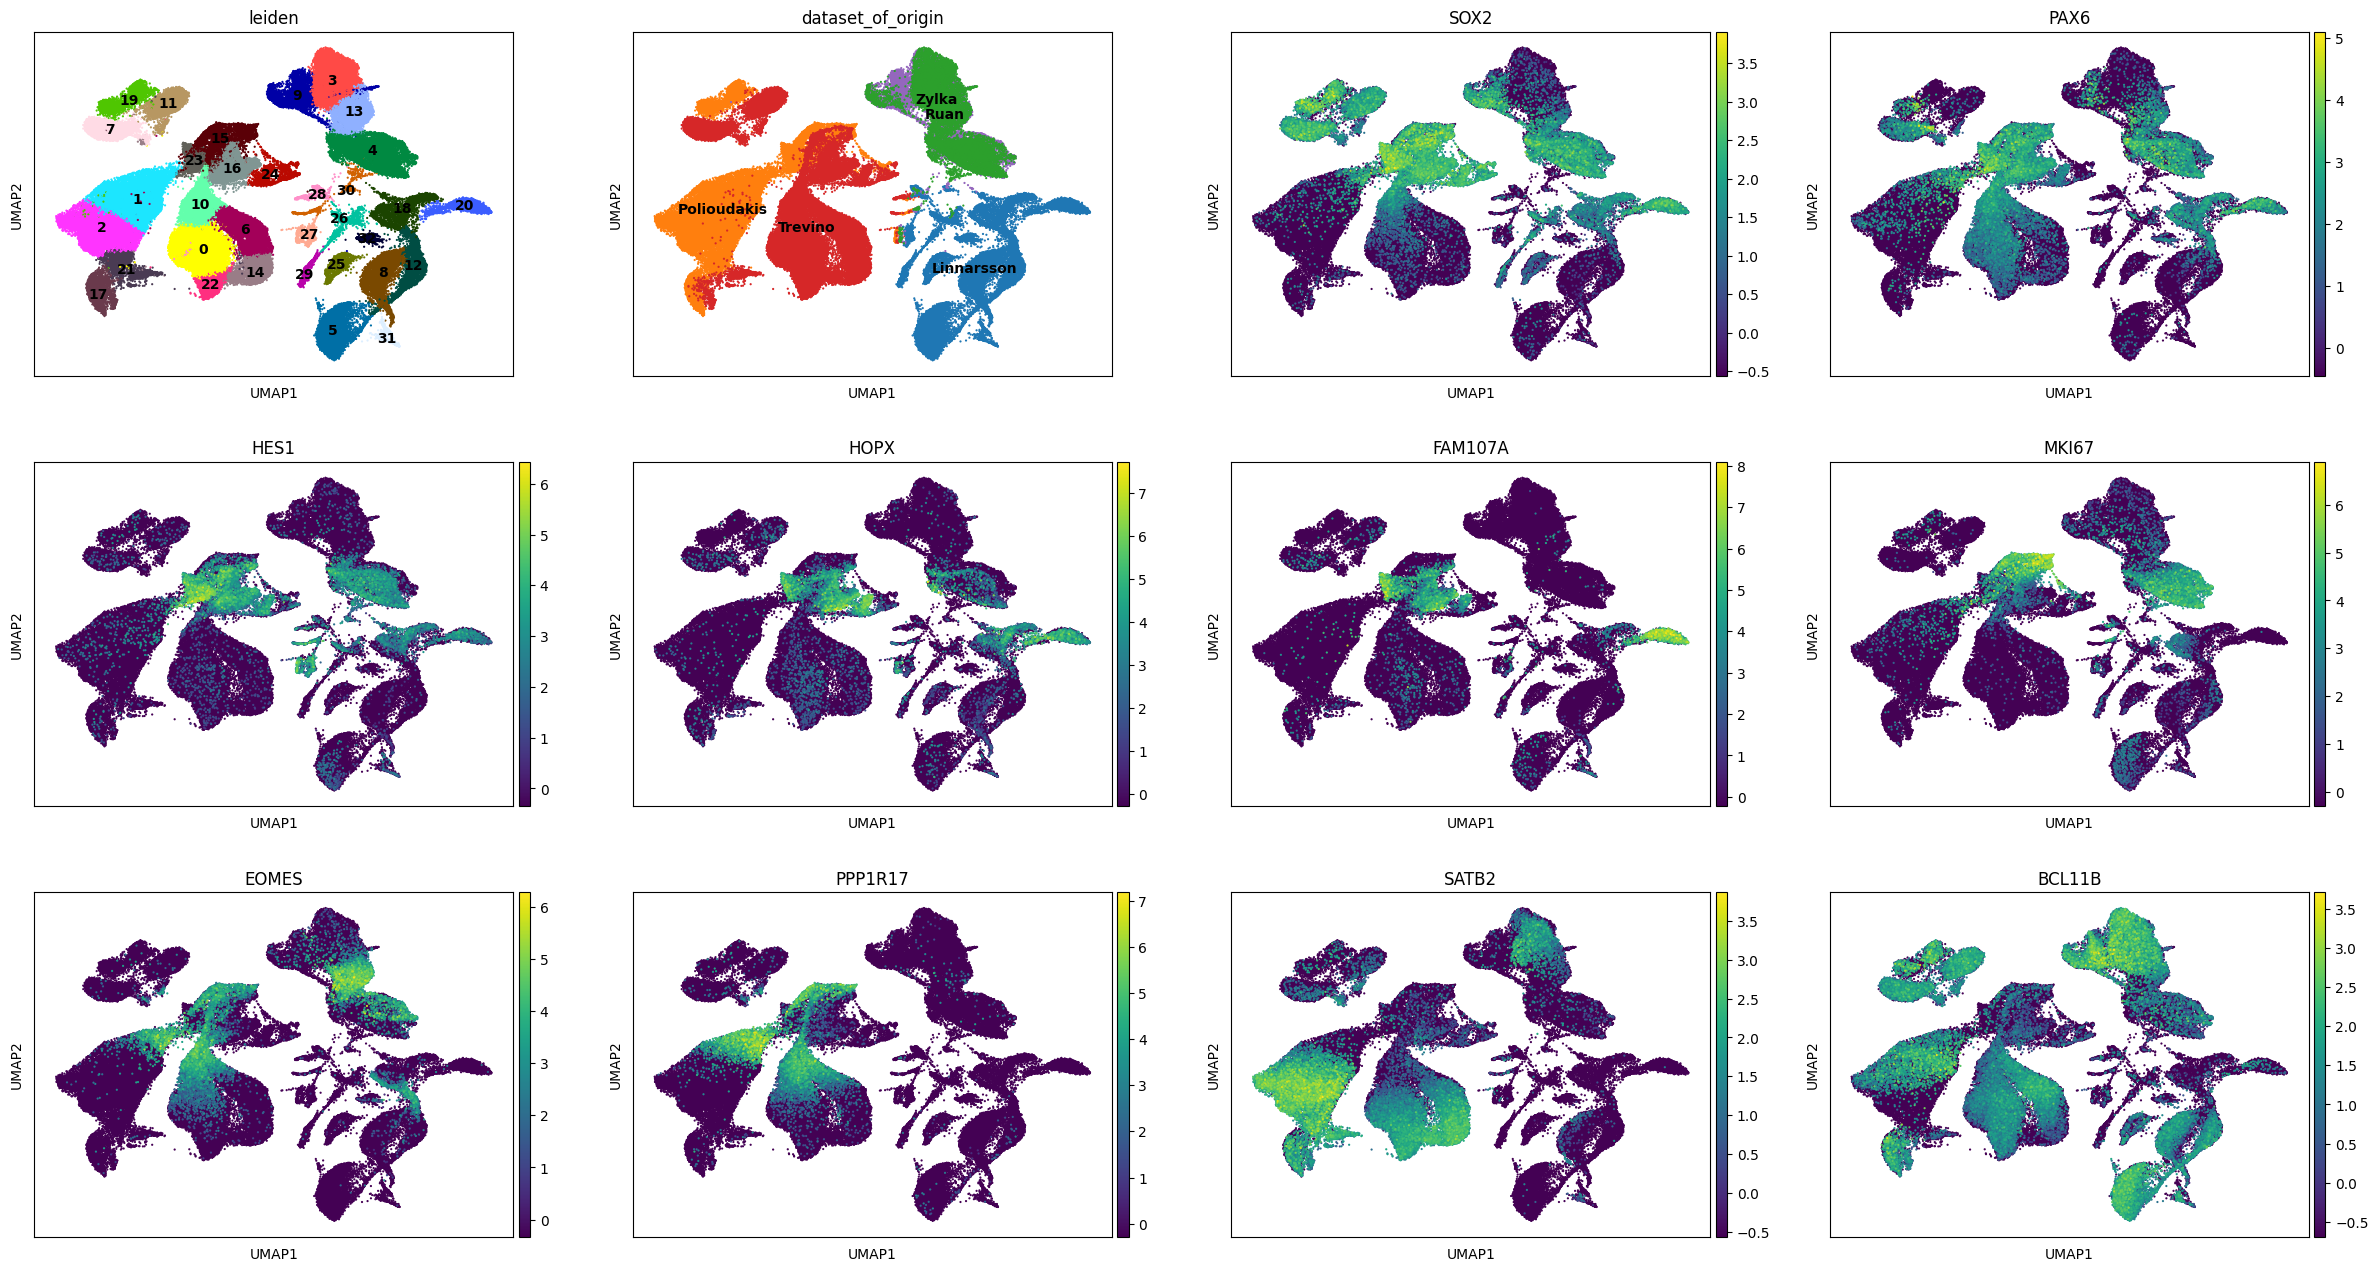

In [22]:
# Plot the UMAPs
sc.pl.umap(adata_combined, color=['leiden', "dataset_of_origin", 'SOX2', 'PAX6', 'HES1', 'HOPX', 'FAM107A', 'MKI67', 'EOMES', 'PPP1R17', 'SATB2', 'BCL11B'],legend_loc="on data", show=False, size = 10)
plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/processing/Adata_concatenated_marker_genes.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [23]:
# Create the df with the expression values of genes of interest 
key_genes_dict = pd.DataFrame({
    'HOPX': adata_combined[:, 'HOPX'].X.flatten(), 
    'FAM107A': adata_combined[:, 'FAM107A'].X.flatten(), 
    'TNC': adata_combined[:, 'TNC'].X.flatten(), 
})

# Add cell indices
key_genes_dict['index'] = adata_combined.obs_names

In [24]:
# Define the threshold for marker genes of interest
## Thresholds are applied by calculating the median absolute deviation by gene of interest. Cells expressing the gene of interest > 2*MAD are considered as positive.
### HOPX
hopx_col = key_genes_dict['HOPX']
hopx_col = pd.DataFrame(hopx_col)
hopx_col = hopx_col[hopx_col['HOPX']>0].values
hopx_col = pd.DataFrame(hopx_col)
hopx_col[[0]].apply(robust.mad)

hopx_positive = key_genes_dict[key_genes_dict['HOPX'] > hopx_col[[0]].apply(robust.mad)[0]*2]
hopx_positive_index = hopx_positive['index']

### FAM107A
fam107a_col = key_genes_dict['FAM107A']
fam107a_col = pd.DataFrame(fam107a_col)
fam107a_col = fam107a_col[fam107a_col['FAM107A']>0].values
fam107a_col = pd.DataFrame(fam107a_col)
fam107a_col[[0]].apply(robust.mad)

fam107a_positive = key_genes_dict[key_genes_dict['FAM107A'] > fam107a_col[[0]].apply(robust.mad)[0]*2]
fam107a_positive_index = fam107a_positive['index']

### TNC
tnc_col = key_genes_dict['TNC']
tnc_col = pd.DataFrame(tnc_col)
tnc_col = tnc_col[tnc_col['TNC']>0].values
tnc_col = pd.DataFrame(tnc_col)
tnc_col[[0]].apply(robust.mad)

tnc_positive = key_genes_dict[key_genes_dict['TNC'] > tnc_col[[0]].apply(robust.mad)[0]*2]
tnc_positive_index = tnc_positive['index']

In [25]:
# Find double/triple positive cells
## HOPX+ TNC+
tnc_positive_index_series = pd.Index(tnc_positive_index)
hopx_positive_index_series = pd.Index(hopx_positive_index)

hopx_tnc_positive_indices = tnc_positive_index_series.intersection(hopx_positive_index_series)

print(len(hopx_tnc_positive_indices))

1495


In [26]:
# Map the HOPX+/FAM107A+/TNC+ cells back to the original anndata
### Individual marker genes
#adata_combined.obs.loc[hopx_positive_index, 'HOPX_or_FAM107A_or_TNC_positive'] = 'hopx_positive'
#adata_combined.obs.loc[fam107a_positive_index, 'HOPX_or_FAM107A_or_TNC_positive'] = 'fam107a_positive'
#adata_combined.obs.loc[tnc_positive_index, 'HOPX_or_FAM107A_or_TNC_positive'] = 'tnc_positive'

### HOPX+/TNC+ combined
adata_combined.obs.loc[hopx_tnc_positive_indices, 'HOPX_and_TNC_positive'] = 'hopx_and_tnc_positive'


In [27]:
# Group by the dataset_of_origin
### Individual marker genes
#adata_combined.obs.groupby('HOPX_or_FAM107A_or_TNC_positive')['dataset_of_origin'].value_counts()
### HOPX+ TNC+ combined
adata_combined.obs.groupby('HOPX_and_TNC_positive')['dataset_of_origin'].value_counts()

HOPX_and_TNC_positive  dataset_of_origin
hopx_and_tnc_positive  Trevino              727
                       Linnarsson           373
                       Polioudakis          302
                       Ruan                  86
                       Zylka                  7
Name: count, dtype: int64

### Save the data

In [28]:
adata_combined.write_h5ad(os.path.join(home_path, 'data_versions/Adata_normalized.h5ad'))

... storing 'HOPX_and_TNC_positive' as categorical
